# Applying statistical modeling and machine learning to perform time-series forecasting.

In [0]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

# set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# read in CSV file data
# This data is from http://insideairbnb.com/get-the-data.html the following under the "New York" section:

url="http://data.insideairbnb.com/united-states/ny/new-york-city/2019-03-06/visualisations/reviews.csv"
df=pd.read_csv(url)

## Look at the dataset

In [2]:
# look at data
print(df.head())
print('-'*50)
# look a shape of data
print(df.shape)
print('-'*50)

# look at data types. Ideally look at all rows. Only look at first five here for minimal output.
print(df.iloc[:5,:5].dtypes)
print('-'*50)

# see if any columns have nulls. Ideally look at all rows. Only look at first five here for minimal output.
print(df.iloc[:5,:5].isnull().any())
print('-'*50)

# display descriptive statistics
print(df.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

   listing_id        date
0        2539  2015-12-04
1        2539  2016-08-27
2        2539  2016-10-01
3        2539  2017-02-20
4        2539  2017-03-19
--------------------------------------------------
(1106639, 2)
--------------------------------------------------
listing_id     int64
date          object
dtype: object
--------------------------------------------------
listing_id    False
date          False
dtype: bool
--------------------------------------------------
         listing_id
count  1.106639e+06
mean   1.132904e+07
std    8.633402e+06
min    2.539000e+03
25%    3.415958e+06
50%    1.007394e+07
75%    1.840233e+07
85%    2.155030e+07
95%    2.652102e+07
99%    2.996548e+07
max    3.282020e+07


**Data.** We have daily count of reviews for given listing ids for given dates.

**Questions we can answer from it **

* Forecast future number of reviews for the Los Angeles area.
* Forecast the future number of reviews for specific listings in the Los Angeles area.

## Process the data

In [3]:
# Rename columns
df = df.rename(columns = {'date': 'ds', 'listing_id': 'ts'})

# Group data by number of listings per date
df_example = df.groupby(by = 'ds').agg({'ts': 'count'})

# Change index to datetime
df_example.index = pd.to_datetime(df_example.index)

# Set frequency of time series
df_example = df_example.asfreq(freq='1D')

# Sort the values
df_example = df_example.sort_index(ascending = True)

# Fill values with 0
df_example = df_example.fillna(value = 0)

# Show the end of the data
print(df_example.tail())

               ts
ds               
2019-03-02  495.0
2019-03-03  955.0
2019-03-04  580.0
2019-03-05  309.0
2019-03-06  186.0


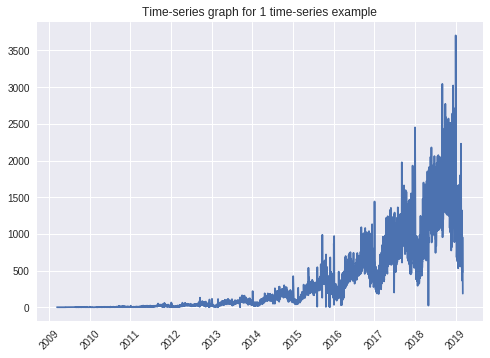

In [4]:
# Plot time series data
f, ax = plt.subplots(1,1)
ax.plot(df_example['ts'])

# Add title
ax.set_title('Time-series graph for 1 time-series example')

# Rotate x-labels
ax.tick_params(axis = 'x', rotation = 45)

# Show graph
plt.show()
plt.close()


- There does appear to be an overall increasing trend. 
- There appears to be some differences in the variance over time. 
- It seems that there is some seasonality (i.e., cycles) in the data.
- Not sure about outliers.


## Look at stationarity
Most time-series models assume that the underlying time-series data is stationary. 

It means that the time-series has:
*   **Constant mean**
*   **Constant variance**
*   **Autocovariance does not depend on time**

We should assume that the data will follow the same general trends and patterns as in the past.  This general statement holds for most training data and modeling tasks.

Sometimes we need to transform the data in order to make it stationary.  However, this  transformation then calls into question if this data is truly stationary and is suited to be modeled using these techniques.



In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

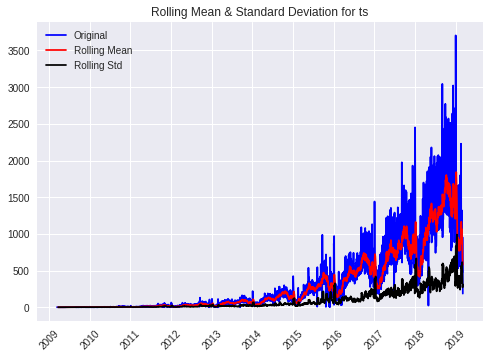

Results of Dickey-Fuller Test:
Test Statistic                   -1.519096
p-value                           0.524044
# Lags Used                      30.000000
Number of Observations Used    3616.000000
Critical Value (1%)              -3.432160
Critical Value (5%)              -2.862340
Critical Value (10%)             -2.567196
dtype: float64


In [6]:
test_stationarity(df = df_example, ts = 'ts')

**Looking at our data:**
- Rolling mean and standard deviation look like they change over time.  There may be some de-trending and removing seasonality involved. Based on **Dickey-Fuller test**, because p = 0.31, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that we fail to reject the null hypothesis that our **time series is not stationary**.


## Correct for stationarity


## Transformation, Smoothing, and Differencing
**Looking at our data:**
- Applying log transformation, weekly moving average smoothing, and differencing made the data more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

In [0]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()
  
  return

,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2009-08-27,3.0,1.098612,0.553029,2.000000,1.098612,1.000000,0.545584,1.098612,0.000000
2009-08-28,1.0,0.000000,0.553029,2.000000,-1.098612,-1.000000,-0.553029,0.522132,-0.522132
2009-10-29,2.0,0.693147,0.495105,1.857143,0.693147,0.142857,0.198042,0.584865,0.108282
2009-10-30,1.0,0.000000,0.495105,1.857143,-0.693147,-0.857143,-0.495105,0.416270,-0.416270
2009-10-31,2.0,0.693147,0.495105,1.857143,0.693147,0.142857,0.198042,0.483116,0.210031


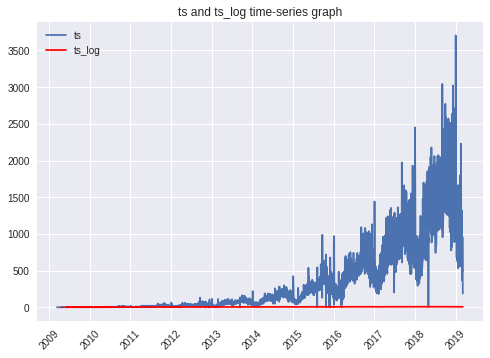

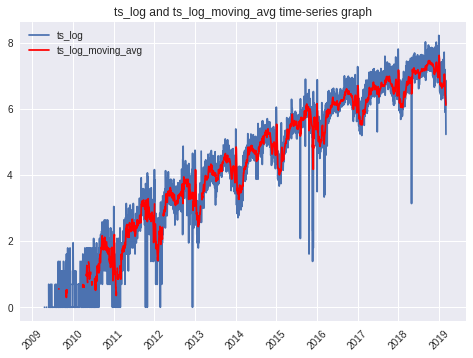

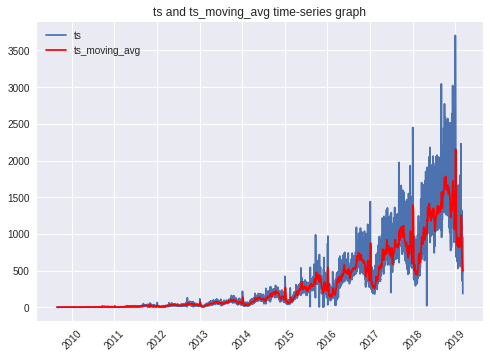

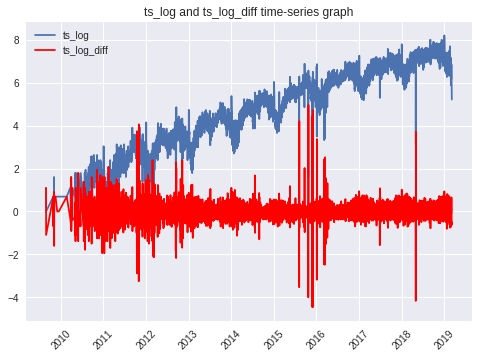

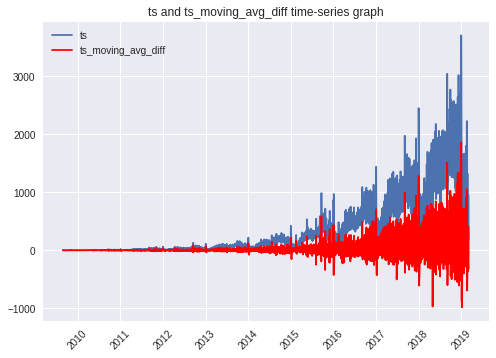

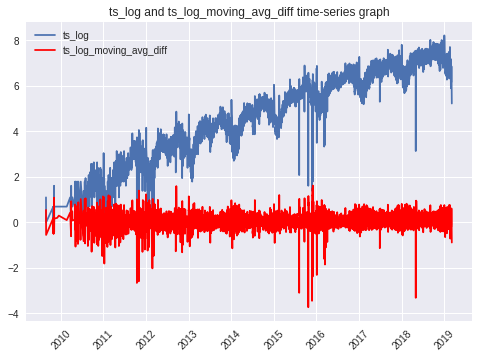

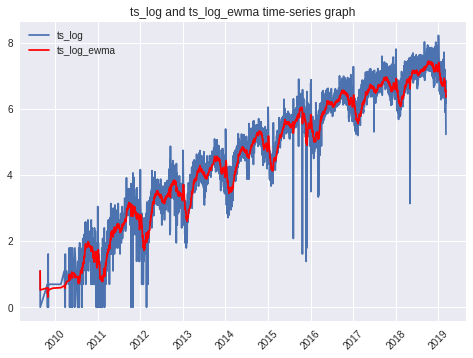

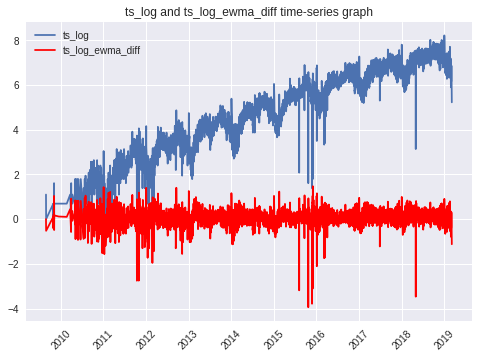

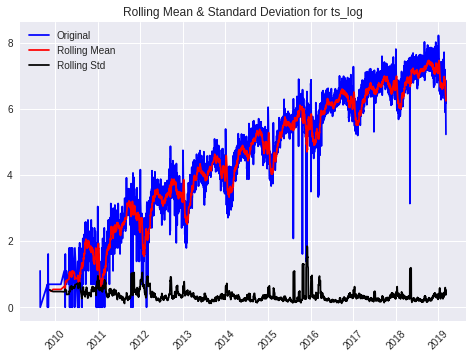

Results of Dickey-Fuller Test:
Test Statistic                   -1.980724
p-value                           0.295088
# Lags Used                      29.000000
Number of Observations Used    3113.000000
Critical Value (1%)              -3.432452
Critical Value (5%)              -2.862469
Critical Value (10%)             -2.567264
dtype: float64


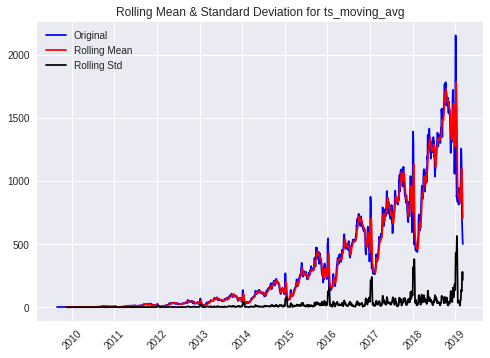

Results of Dickey-Fuller Test:
Test Statistic                   -1.383109
p-value                           0.590347
# Lags Used                      29.000000
Number of Observations Used    3113.000000
Critical Value (1%)              -3.432452
Critical Value (5%)              -2.862469
Critical Value (10%)             -2.567264
dtype: float64


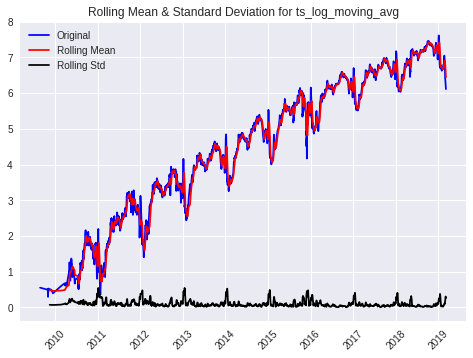

Results of Dickey-Fuller Test:
Test Statistic                   -2.014310
p-value                           0.280334
# Lags Used                      28.000000
Number of Observations Used    3114.000000
Critical Value (1%)              -3.432452
Critical Value (5%)              -2.862469
Critical Value (10%)             -2.567264
dtype: float64


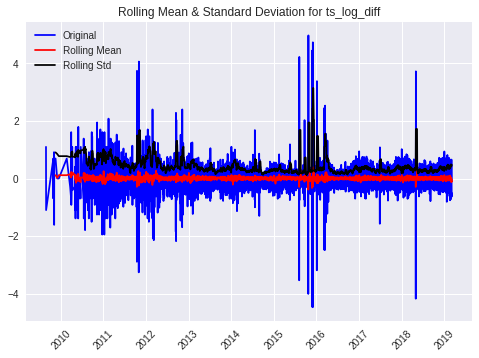

Results of Dickey-Fuller Test:
Test Statistic                -1.161064e+01
p-value                        2.518073e-21
# Lags Used                    2.900000e+01
Number of Observations Used    3.113000e+03
Critical Value (1%)           -3.432452e+00
Critical Value (5%)           -2.862469e+00
Critical Value (10%)          -2.567264e+00
dtype: float64


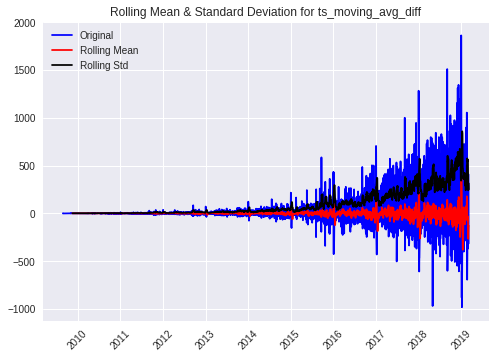

Results of Dickey-Fuller Test:
Test Statistic                -1.186759e+01
p-value                        6.619115e-22
# Lags Used                    2.900000e+01
Number of Observations Used    3.113000e+03
Critical Value (1%)           -3.432452e+00
Critical Value (5%)           -2.862469e+00
Critical Value (10%)          -2.567264e+00
dtype: float64


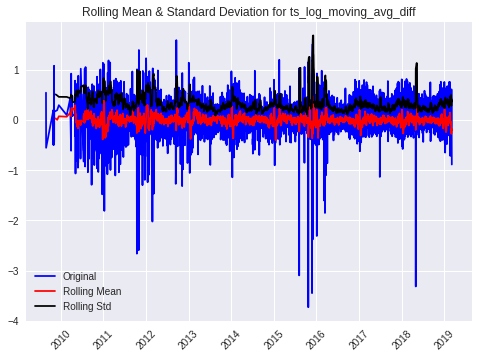

Results of Dickey-Fuller Test:
Test Statistic                -1.148879e+01
p-value                        4.792655e-21
# Lags Used                    2.700000e+01
Number of Observations Used    3.115000e+03
Critical Value (1%)           -3.432451e+00
Critical Value (5%)           -2.862468e+00
Critical Value (10%)          -2.567264e+00
dtype: float64


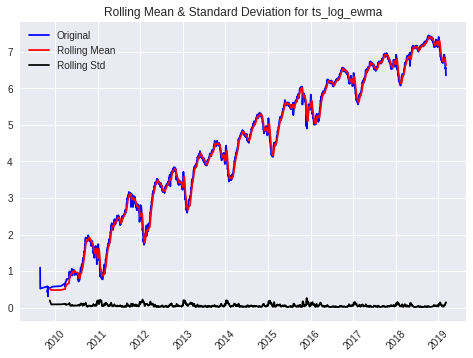

Results of Dickey-Fuller Test:
Test Statistic                   -2.003149
p-value                           0.285194
# Lags Used                      28.000000
Number of Observations Used    3114.000000
Critical Value (1%)              -3.432452
Critical Value (5%)              -2.862469
Critical Value (10%)             -2.567264
dtype: float64


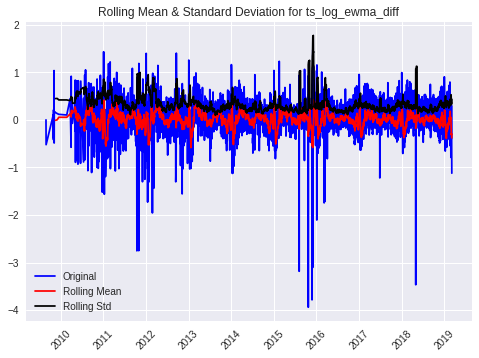

Results of Dickey-Fuller Test:
Test Statistic                -8.179628e+00
p-value                        8.197766e-13
# Lags Used                    2.700000e+01
Number of Observations Used    3.115000e+03
Critical Value (1%)           -3.432451e+00
Critical Value (5%)           -2.862468e+00
Critical Value (10%)          -2.567264e+00
dtype: float64


In [8]:
# Transformation - log ts
df_example['ts_log'] = df_example['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
# df_example['ts_log_diff'] = df_example['ts_log'] - df_example['ts_log'].shift()
df_example['ts_log_diff'] = df_example['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example['ts'] - df_example['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example['ts_log'] - df_example['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example_transform = df_example.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']

# Display data
display(df_example_transform.head())

# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_ewma_diff')

## Decomposition: trend, seasonality, residuals


In [0]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

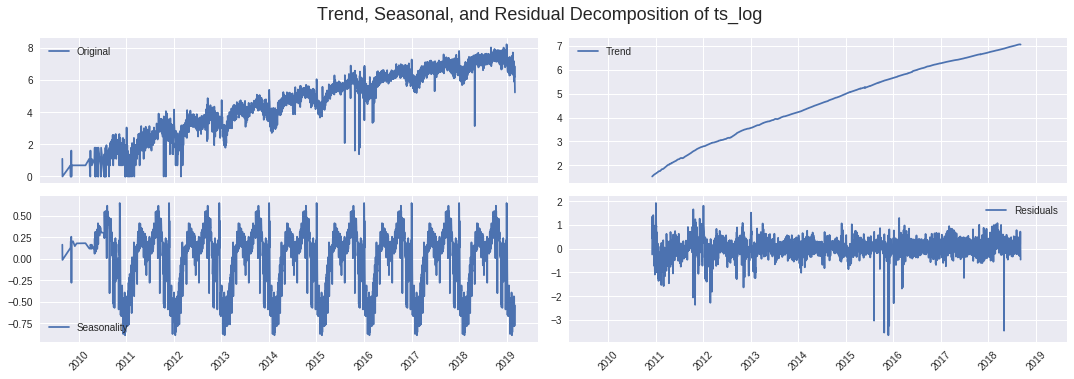

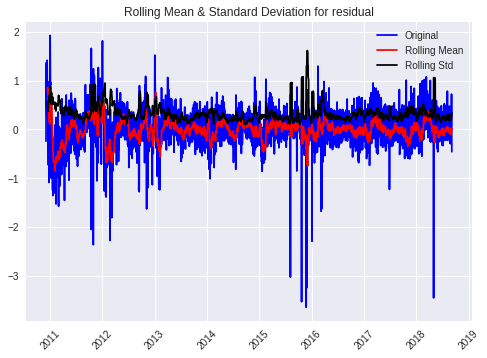

Results of Dickey-Fuller Test:
Test Statistic                -6.680711e+00
p-value                        4.349497e-09
# Lags Used                    2.700000e+01
Number of Observations Used    2.751000e+03
Critical Value (1%)           -3.432729e+00
Critical Value (5%)           -2.862591e+00
Critical Value (10%)          -2.567330e+00
dtype: float64


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')

**Looking at our data:**
- De-trending and de-seasonalizing made the data (i.e., the residuals) more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

# Model the time-series data

##ARIMA models.

We will be doing an example here! We can use ARIMA models when we know there is dependence between values and we can leverage that information to forecast.

## ACF and PACF Plots
**How do we determine p, d, and q?**
For p and q, we can use ACF and PACF plots (below).

**Autocorrelation Function (ACF).** Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).

**Partial Autocorrelation Function (PACF).** Additional correlation explained by each successive lagged term.

**How do we interpret ACF and PACF plots?**
- p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – Lag value where the ACF chart crosses the upper confidence interval for the first time.


In [0]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

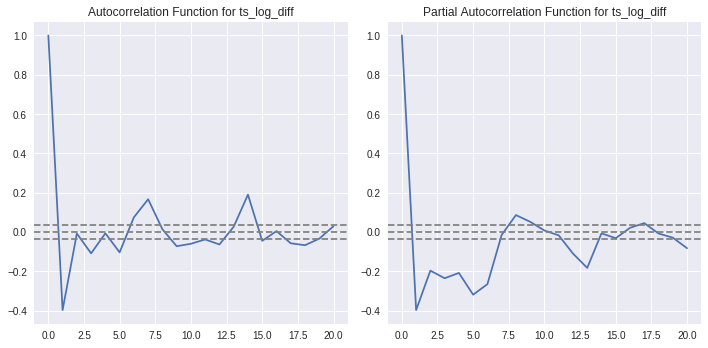

In [12]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(df_example_transform['ts_log_diff']), nlags = 20)
lag_pacf = pacf(np.array(df_example_transform['ts_log_diff']), nlags = 20)

# plot ACF and PACF
plot_acf_pacf(df = df_example_transform, ts = 'ts_log_diff')

In [0]:
def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  """
  from statsmodels.tsa.arima_model import ARIMA

  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
  plt.show()
  plt.close()
  
  return results_

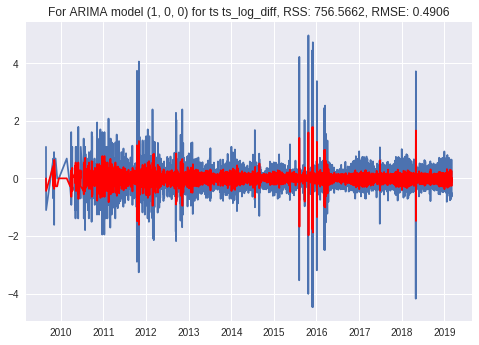

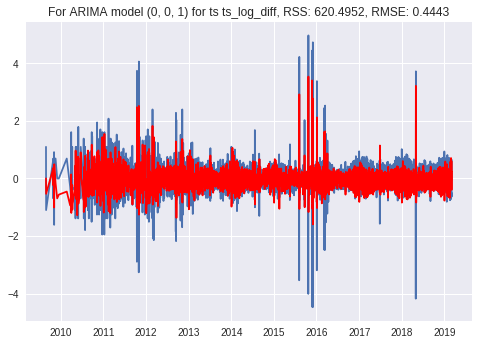

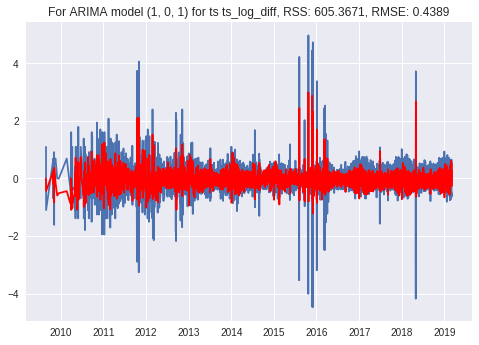

In [14]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_MA = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_MA = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 1)

##Facebook Prophet package.

 [Facebook Prophet](https://facebook.github.io/prophet/) allows to forecast using additive or component models relatively easily.  It can also include things like:
* Day of week effects
* Day of year effects
* Holiday effects
* Trend trajectory

In [0]:
from fbprophet import Prophet
import datetime
from datetime import datetime

In [0]:
def days_between(d1, d2):
    """Calculate the number of days between two dates.  D1 is start date (inclusive) and d2 is end date (inclusive)"""
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days + 1)

In [0]:
# Inputs for query

date_column = 'dt'
metric_column = 'ts'
table = df_example
start_training_date = '2010-07-03'
end_training_date = '2018-09-08'
start_forecasting_date = '2018-09-09'
end_forecasting_date = '2018-12-31'
year_to_estimate = '2018'

# Inputs for forecasting

# future_num_points
# If doing different time intervals, change future_num_points
future_num_points = days_between(start_forecasting_date, end_forecasting_date)

cap = None # 2e6

# growth: default = 'linear'
# Can also choose 'logistic'
growth = 'linear'

# n_changepoints: default = 25, uniformly placed in first 80% of time series
n_changepoints = 25 

# changepoint_prior_scale: default = 0.05
# Increasing it will make the trend more flexible
changepoint_prior_scale = 0.05 

# changpoints: example = ['2016-01-01']
changepoints = None 

# holidays_prior_scale: default = 10
# If you find that the holidays are overfitting, you can adjust their prior scale to smooth them
holidays_prior_scale = 10 

# interval_width: default = 0.8
interval_width = 0.8 

# mcmc_samples: default = 0
# By default Prophet will only return uncertainty in the trend and observation noise.
# To get uncertainty in seasonality, you must do full Bayesian sampling. 
# Replaces typical MAP estimation with MCMC sampling, and takes MUCH LONGER - e.g., 10 minutes instead of 10 seconds.
# If you do full sampling, then you will see the uncertainty in seasonal components when you plot:
mcmc_samples = 0

# holiday: default = None
# thanksgiving = pd.DataFrame({
#   'holiday': 'thanksgiving',
#   'ds': pd.to_datetime(['2014-11-27', '2015-11-26',
#                         '2016-11-24', '2017-11-23']),
#   'lower_window': 0,
#   'upper_window': 4,
# })
# christmas = pd.DataFrame({
#   'holiday': 'christmas',
#   'ds': pd.to_datetime(['2014-12-25', '2015-12-25', 
#                         '2016-12-25','2017-12-25']),
#   'lower_window': -1,
#   'upper_window': 0,
# })
# holidays = pd.concat((thanksgiving,christmas))
holidays = None

daily_seasonality = True

In [0]:
# get relevant data - note: could also try this with ts_log_diff
df_prophet = df_example_transform[['ts']] # can try with ts_log_diff

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'ds': 'ds', 'ts': 'y'}) # can try with ts_log_diff

# Change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='ignore')

# Remove any outliers
# df.loc[(df_['ds'] > '2016-12-13') & (df_['ds'] < '2016-12-19'), 'y'] = None

In [0]:
def create_daily_forecast(df,
#                           cap,
                          holidays,
                          growth,
                          n_changepoints = 25,
                          changepoint_prior_scale = 0.05,
                          changepoints = None,
                          holidays_prior_scale = 10,
                          interval_width = 0.8,
                          mcmc_samples = 1,
                          future_num_points = 10, 
                          daily_seasonality = True):
  """
  Create forecast
  """
  
  # Create copy of dataframe
  df_ = df.copy()

  # Add in growth parameter, which can change over time
  #     df_['cap'] = max(df_['y']) if cap is None else cap

  # Create model object and fit to dataframe
  m = Prophet(growth = growth,
              n_changepoints = n_changepoints,
              changepoint_prior_scale = changepoint_prior_scale,
              changepoints = changepoints,
              holidays = holidays,
              holidays_prior_scale = holidays_prior_scale,
              interval_width = interval_width,
              mcmc_samples = mcmc_samples, 
              daily_seasonality = daily_seasonality)

  # Fit model with dataframe
  m.fit(df_)

  # Create dataframe for predictions
  future = m.make_future_dataframe(periods = future_num_points)
  #     future['cap'] = max(df_['y']) if cap is None else cap

  # Create predictions
  fcst = m.predict(future)

  # Plot
  m.plot(fcst);
  m.plot_components(fcst)

  return fcst

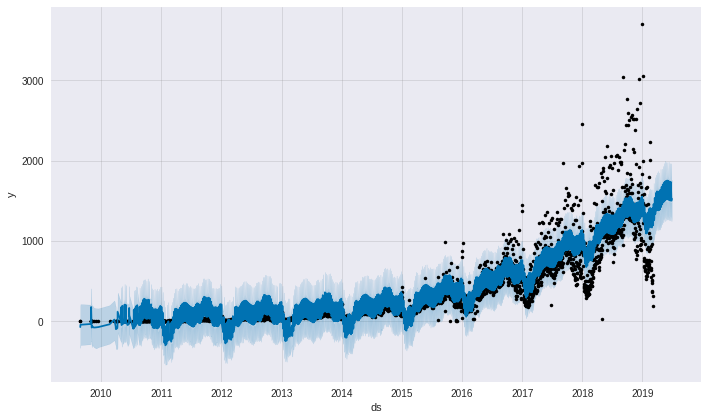

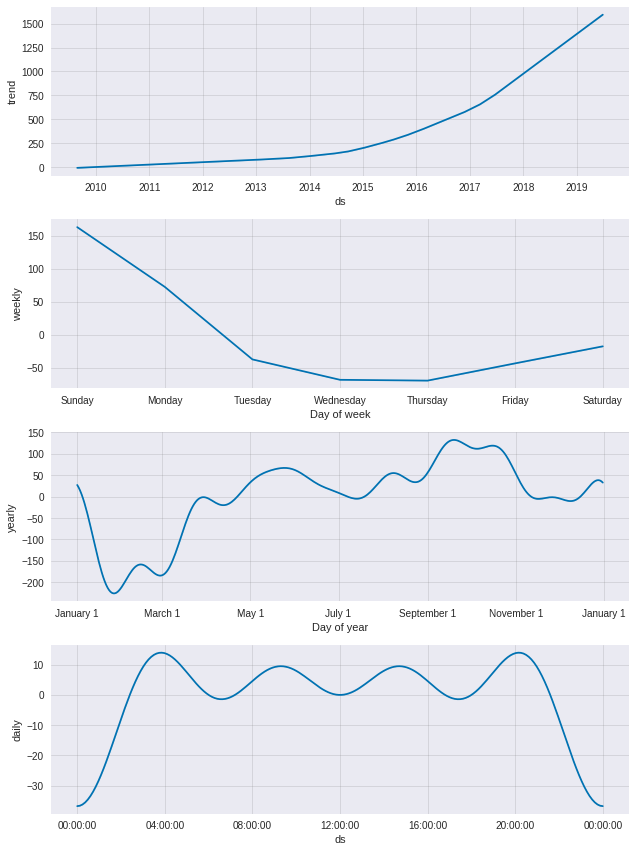

In [20]:
fcst = create_daily_forecast(df_prophet,
#                              cap,
                             holidays,
                             growth,
                             n_changepoints,
                             changepoint_prior_scale,
                             changepoints, 
                             holidays_prior_scale,
                             interval_width,
                             mcmc_samples,
                             future_num_points, 
                             daily_seasonality)

In [0]:
def calculate_mape(y_true, y_pred):
    """ Calculate mean absolute percentage error (MAPE)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mpe(y_true, y_pred):
    """ Calculate mean percentage error (MPE)"""
    return np.mean((y_true - y_pred) / y_true) * 100

def calculate_mae(y_true, y_pred):
    """ Calculate mean absolute error (MAE)"""
    return np.mean(np.abs(y_true - y_pred)) * 100

def calculate_rmse(y_true, y_pred):
    """ Calculate root mean square error (RMSE)"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def print_error_metrics(y_true, y_pred):
    print('MAPE: %f'%calculate_mape(y_true, y_pred))
    print('MPE: %f'%calculate_mpe(y_true, y_pred))
    print('MAE: %f'%calculate_mae(y_true, y_pred))
    print('RMSE: %f'%calculate_rmse(y_true, y_pred))
    return

In [22]:
print_error_metrics(y_true = df_prophet['y'], y_pred = fcst['yhat'])

MAPE: 499.796872
MPE: 147.995646
MAE: 11355.919362
RMSE: 191.409727


##LSTM for regression


In [0]:
def do_lstm_model(df, 
                  ts, 
                  look_back, 
                  epochs, 
                  type_ = None, 
                  train_fraction = 0.67):
  """
   Create LSTM model
   Source: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
  """
  # Import packages
  import numpy
  import matplotlib.pyplot as plt
  from pandas import read_csv
  import math
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.metrics import mean_squared_error

  # Convert an array of values into a dataset matrix
  def create_dataset(dataset, look_back=1):
    """
    Create the dataset
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back), 0]
      dataX.append(a)
      dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

  # Fix random seed for reproducibility
  numpy.random.seed(7)

  # Get dataset
  dataset = df[ts].values
  dataset = dataset.astype('float32')

  # Normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset.reshape(-1, 1))
  
  # Split into train and test sets
  train_size = int(len(dataset) * train_fraction)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
  # Reshape into X=t and Y=t+1
  look_back = look_back
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  
  # Reshape input to be [samples, time steps, features]
  if type_ == 'regression with time steps':
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  elif type_ == 'stacked with memory between batches':
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
  else:
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  
  # Create and fit the LSTM network
  batch_size = 1
  model = Sequential()
  
  if type_ == 'regression with time steps':
    model.add(LSTM(4, input_shape=(look_back, 1)))
  elif type_ == 'memory between batches':
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  elif type_ == 'stacked with memory between batches':
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  else:
    model.add(LSTM(4, input_shape=(1, look_back)))
  
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    for i in range(100):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
      model.reset_states()
  else:
    model.fit(trainX, 
              trainY, 
              epochs = epochs, 
              batch_size = 1, 
              verbose = 2)
  
  # Make predictions
  if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)
  else:
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
  
  # Invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  
  # Calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  
  # Shift train predictions for plotting
  trainPredictPlot = numpy.empty_like(dataset)
  trainPredictPlot[:, :] = numpy.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  
  # Shift test predictions for plotting
  testPredictPlot = numpy.empty_like(dataset)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
  
  # Plot baseline and predictions
  plt.plot(scaler.inverse_transform(dataset))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.show()
  plt.close()
  
  return

Epoch 1/5
 - 5s - loss: 6.3283e-04
Epoch 2/5
 - 3s - loss: 3.5860e-04
Epoch 3/5
 - 3s - loss: 3.5207e-04
Epoch 4/5
 - 3s - loss: 3.5654e-04
Epoch 5/5
 - 3s - loss: 3.5289e-04
Train Score: 67.79 RMSE
Test Score: 354.27 RMSE


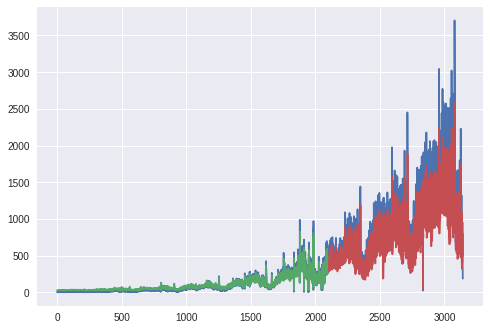

In [25]:
# LSTM Network for Regression
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 1, 
              epochs = 5)


Epoch 1/5
 - 5s - loss: 6.1155e-04
Epoch 2/5
 - 3s - loss: 3.0597e-04
Epoch 3/5
 - 3s - loss: 2.9952e-04
Epoch 4/5
 - 3s - loss: 2.9737e-04
Epoch 5/5
 - 3s - loss: 2.9624e-04
Train Score: 77.23 RMSE
Test Score: 366.01 RMSE


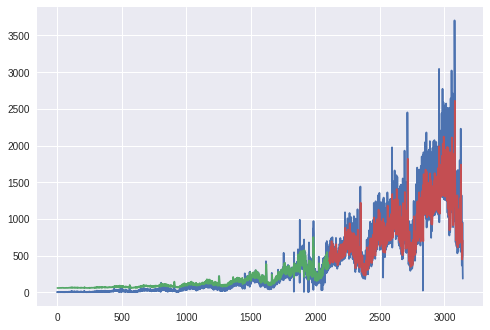

In [27]:
# LSTM for Regression Using the Window Method
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 3, 
              epochs = 5)


Epoch 1/5
 - 6s - loss: 4.2463e-04
Epoch 2/5
 - 5s - loss: 3.0155e-04
Epoch 3/5
 - 5s - loss: 2.9808e-04
Epoch 4/5
 - 5s - loss: 2.9840e-04
Epoch 5/5
 - 5s - loss: 2.9790e-04
Train Score: 82.77 RMSE
Test Score: 353.37 RMSE


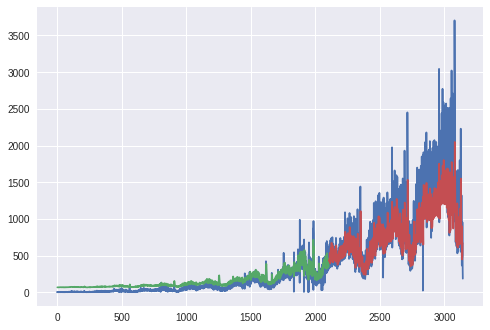

In [28]:

# LSTM for Regression with Time Steps
do_lstm_model(df = df_prophet, 
              ts = 'y', 
              look_back = 3, 
              epochs = 5, 
              type_ = 'regression with time steps')
